In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
from IPython.display import HTML
import random
import time

class SmartOfficeEnv(gym.Env):
    metadata = {"render_modes": ["rgb_array"]}

    def __init__(self, render_mode="rgb_array"):
        self.render_mode = render_mode

        # Comfort Range
        self.COMFORT_RANGE = (22.0, 24.0)

        # Discretization Bins
        self.bins_room = np.array([15, 18, 20, 21, 22, 23, 23.5, 24, 25, 26, 28, 30])
        self.bins_outside = np.array([-5, 0, 5, 10, 15, 20, 25, 30, 35, 40])

        # Action Effects (Temp Change)
        self.ACTION_EFFECTS = {
            0: 0.0, 1: -0.5, 2: -1.5, 3: -3.0,
            4: 0.5, 5: 1.5, 6: 3.0
        }

        # Energy Costs
        self.ENERGY_CONSUMPTION = {
            0: 0.0, 1: 0.5, 2: 1.0, 3: 2.0,
            4: 0.5, 5: 1.0, 6: 2.0
        }

        # Visualization params
        self.ACTION_VISUALS = {
            0: (0, 0), 1: (-1, 1), 2: (-1, 2), 3: (-1, 3),
            4: (1, 1), 5: (1, 2), 6: (1, 3)
        }

        self.action_space = spaces.Discrete(7)
        # Observation: [Room Temp Index, Outside Temp Index, Time Period]
        self.observation_space = spaces.MultiDiscrete([13, 11, 5])

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.room_temp = self.np_random.uniform(18, 28)
        self.outside_temp = self.np_random.uniform(10, 30)
        self.hour = 0
        self.current_energy = 0.0
        self.last_action = 0
        self.step_count = 0
        return self._get_obs(), {"action_mask": np.ones(7, dtype=np.int8)}

    def _get_time_period(self, hour):
        if 0 <= hour <= 5: return 0   # Night
        if 6 <= hour <= 8: return 1   # Prep
        if 9 <= hour <= 17: return 2  # Work
        if 18 <= hour <= 23: return 3 # Evening
        return 0

    def _get_obs(self):
        room_idx = np.digitize(self.room_temp, self.bins_room)
        out_idx = np.digitize(self.outside_temp, self.bins_outside)
        time_idx = self._get_time_period(self.hour)
        return np.array([room_idx, out_idx, time_idx], dtype=np.int32)

    def step(self, action):
        self.last_action = action
        change = self.ACTION_EFFECTS[action]
        cost = self.ENERGY_CONSUMPTION[action]
        self.current_energy = cost

        # Physics simulation
        diff = self.outside_temp - self.room_temp
        self.room_temp += diff * 0.08
        self.room_temp += change

        reward = 0
        time_period = self._get_time_period(self.hour)

        # 1. WORK HOURS (09:00 - 17:00)
        if time_period == 2:
            in_comfort = (self.COMFORT_RANGE[0] <= self.room_temp <= self.COMFORT_RANGE[1])

            if in_comfort:
                # Noon Shield (11:00 - 16:00): Do not turn off if temp > 22.8
                if 11 <= self.hour <= 16 and self.room_temp > 22.8 and action == 0:
                     reward = -500.0

                # Normal hours: Do not turn off if > 23.5
                elif self.room_temp > 23.5 and action == 0:
                    reward = -100.0

                elif action == 0:
                    reward = 100.0   # Save energy if safe
                else:
                    reward = 80.0 - (cost * 5.0)
            else:
                dist = min(abs(self.room_temp - 22.0), abs(self.room_temp - 24.0))
                penalty = dist * 50.0
                if action == 0: penalty += 300.0 # Must not turn off if uncomfortable
                reward = -penalty

        # 2. MORNING PREP (06:00 - 08:00)
        elif time_period == 1:
            # Goal: Reach < 23.0
            if self.room_temp > 23.0:
                if action == 0:
                    reward = -200.0
                elif action >= 4:
                    reward = -500.0 # Don't heat if already hot
                else:
                    reward = 50.0 - cost
            else:
                if action == 0: reward = 20.0
                else: reward = -cost * 10.0

        # 3. RESTRICTED ZONES (NIGHT & EVENING)
        else:
            if action == 0:
                reward = 20.0
            else:
                reward = -200.0 # FORBIDDEN

        self.step_count += 1
        self.hour = (self.hour + 1) % 24

        # Outside temp simulation
        if 6 <= self.hour < 15: self.outside_temp += 0.5
        elif self.hour >= 15 or self.hour < 5: self.outside_temp -= 0.5

        terminated = (self.step_count >= 24)
        return self._get_obs(), reward, terminated, False, {}

    def render(self):
        fig = plt.figure(figsize=(6, 6), dpi=100)
        ax = fig.add_axes([0, 0, 1, 1])
        ax.set_xlim(0, 10)
        ax.set_ylim(0, 10)
        ax.axis('off')

        time_p = self._get_time_period(self.hour)
        bg_alpha = 0.6 if time_p == 2 else 0.2

        if self.COMFORT_RANGE[0] <= self.room_temp <= self.COMFORT_RANGE[1]:
            bg_color = '#90EE90'
        else:
            bg_color = 'orange'

        ax.add_patch(patches.Rectangle((1, 1), 8, 8, facecolor=bg_color,
                                       edgecolor="black", lw=3, alpha=bg_alpha))

        period_names = ["NIGHT", "PREP", "WORK", "EVENING"]
        ax.text(5, 9.2, period_names[time_p], fontsize=14, ha='center',
                fontweight='bold', bbox=dict(facecolor='white'))

        ax.add_patch(patches.Rectangle((3.5, 6), 3, 1.5, facecolor="#E0E0E0"))
        ax.text(5, 6.75, "AC UNIT", ha='center', fontsize=10, fontweight='bold')

        mode, level = self.ACTION_VISUALS[self.last_action]
        if level > 0:
            color = "dodgerblue" if mode == -1 else "crimson"
            for i in range(level):
                ax.add_patch(patches.Rectangle(
                    (4 + (i * 0.4) - ((level - 1) * 0.2), 5.9 - (0.5 + i * 0.2)),
                    0.3, 0.5 + i * 0.2, facecolor=color
                ))

        ax.text(2, 8.5, f"{self.hour:02d}:00", fontsize=16, fontweight='bold',
                bbox=dict(facecolor='white'))
        ax.text(5, 4, f"In: {self.room_temp:.1f}°C", fontsize=22, ha='center', fontweight='bold')
        ax.text(5, 3, f"Out: {self.outside_temp:.1f}°C", fontsize=12, ha='center')
        ax.text(5, 2, f"Power: {self.current_energy:.1f} kW", fontsize=10, ha='center', color='red')

        fig.canvas.draw()
        img = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (4,))[:, :, :3]
        plt.close(fig)
        return img

def create_office_env():
    return SmartOfficeEnv()

SMART OFFICE AC SYSTEM - ENVIRONMENT INFO
Observation Space: MultiDiscrete([13 11  5])
Action Space: 7 (0=Off, 1-3=Cool, 4-6=Heat)
Comfort Range: 22.0-24.0°C
Work Hours: 09:00-17:00

[TEST STEP]
Action: 3
Observation: [5 5 0]
Reward: -200.00
Room Temp: 22.2°C


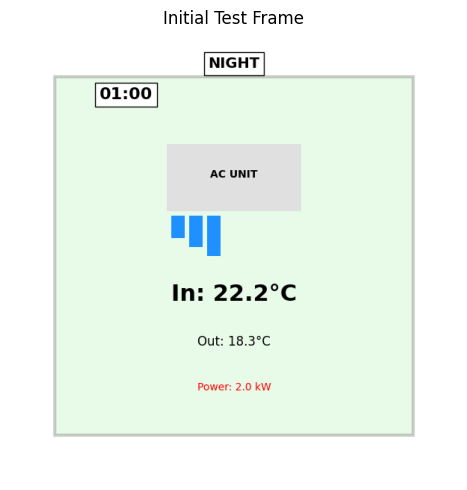

In [2]:
env = create_office_env()
obs, info = env.reset(seed=42)

print("=" * 60)
print("SMART OFFICE AC SYSTEM - ENVIRONMENT INFO")
print("=" * 60)
print(f"Observation Space: {env.observation_space}")
print(f"Action Space: {env.action_space.n} (0=Off, 1-3=Cool, 4-6=Heat)")
print(f"Comfort Range: {env.COMFORT_RANGE[0]}-{env.COMFORT_RANGE[1]}°C")
print(f"Work Hours: 09:00-17:00")
print("=" * 60)

# Single Step Test
action = env.action_space.sample()
next_obs, reward, terminated, truncated, info = env.step(action)

print(f"\n[TEST STEP]")
print(f"Action: {action}")
print(f"Observation: {next_obs}")
print(f"Reward: {reward:.2f}")
print(f"Room Temp: {env.room_temp:.1f}°C")

frame = env.render()
plt.figure(figsize=(5, 5))
plt.imshow(frame)
plt.axis("off")
plt.title("Initial Test Frame")
plt.tight_layout()
plt.show()

In [3]:
# Standard Hot Summer Day Scenario
STANDARD_TEMPS = [20, 19, 19, 20, 21, 22, 24, 26, 28, 30, 32, 34,
                  35, 35, 34, 32, 30, 29, 28, 27, 26, 25, 24, 23]

def run_random_scenario(env, temps=STANDARD_TEMPS):
    obs, _ = env.reset(seed=42)
    env.room_temp = 28  # Start hot

    frames = []
    total_reward = 0
    total_energy = 0
    fail_count = 0

    print("\n" + "=" * 60)
    print("RANDOM AGENT - 24 HOUR TEST")
    print("=" * 60)

    for h in range(24):
        env.outside_temp = temps[h]
        env.hour = h

        action = env.action_space.sample()
        obs, reward, terminated, _, _ = env.step(action)

        frames.append(env.render())
        total_reward += reward
        total_energy += env.current_energy

        # Check comfort during work hours
        if 9 <= h <= 17:
            if not (22.0 <= env.room_temp <= 24.0):
                fail_count += 1
                print(f"⚠️  Hour {h:02d}:00 - Discomfort: {env.room_temp:.1f}°C")

    print("=" * 60)
    print(f"Total Reward: {total_reward:.1f}")
    print(f"Total Energy: {total_energy:.1f} kW")
    print(f"Work Violations: {fail_count}/9 hours")
    print(f"Comfort Rate: %{((9 - fail_count) / 9 * 100):.1f}")
    print("=" * 60)

    return frames

def show_animation(frames):
    fig = plt.figure(figsize=(6, 6))
    plt.axis('off')
    im = plt.imshow(frames[0])

    def update(frame):
        im.set_array(frame)
        return [im]

    anim = animation.FuncAnimation(fig, update, frames=frames,
                                   interval=200, blit=True)
    plt.close(fig)
    return anim

env = create_office_env()
random_frames = run_random_scenario(env, STANDARD_TEMPS)
random_anim = show_animation(random_frames)
HTML(random_anim.to_jshtml())


RANDOM AGENT - 24 HOUR TEST
⚠️  Hour 09:00 - Discomfort: 21.7°C
⚠️  Hour 11:00 - Discomfort: 27.8°C
⚠️  Hour 12:00 - Discomfort: 25.4°C
⚠️  Hour 13:00 - Discomfort: 29.1°C
⚠️  Hour 14:00 - Discomfort: 29.5°C
⚠️  Hour 15:00 - Discomfort: 29.7°C
⚠️  Hour 16:00 - Discomfort: 26.8°C
⚠️  Hour 17:00 - Discomfort: 26.9°C
Total Reward: -4814.9
Total Energy: 22.5 kW
Work Violations: 8/9 hours
Comfort Rate: %11.1


SMART OFFICE AC - TRAINING START (STRICT)

🚀 TRAINING IN PROGRESS...
Ep: 2,000 | Eps: 0.819 | Comfort: % 77.8 | Energy:  7.5 kW | Reward:  866.9 | RECORD (Comfort)!
Ep: 4,000 | Eps: 0.670 | Comfort: % 84.4 | Energy:  7.4 kW | Reward:  915.9 | RECORD (Comfort)!
Ep: 6,000 | Eps: 0.549 | Comfort: % 88.9 | Energy:  7.2 kW | Reward:  935.6 | RECORD (Comfort)!
Ep: 8,000 | Eps: 0.449 | Comfort: % 86.7 | Energy:  7.0 kW | Reward:  911.2 | 
Ep: 10,000 | Eps: 0.368 | Comfort: % 84.4 | Energy:  8.3 kW | Reward:  868.9 | 
Ep: 12,000 | Eps: 0.301 | Comfort: % 83.3 | Energy:  8.4 kW | Reward:  875.1 | 
Ep: 14,000 | Eps: 0.247 | Comfort: % 86.7 | Energy:  7.6 kW | Reward:  935.2 | 
Ep: 16,000 | Eps: 0.202 | Comfort: % 82.2 | Energy:  7.7 kW | Reward:  891.6 | 
Ep: 18,000 | Eps: 0.165 | Comfort: % 84.4 | Energy:  8.2 kW | Reward:  887.6 | 
Ep: 20,000 | Eps: 0.135 | Comfort: % 90.0 | Energy:  8.5 kW | Reward:  891.1 | RECORD (Comfort)!
Ep: 22,000 | Eps: 0.111 | Comfort: % 90.0 | Energy:  7.2 kW | Rewar

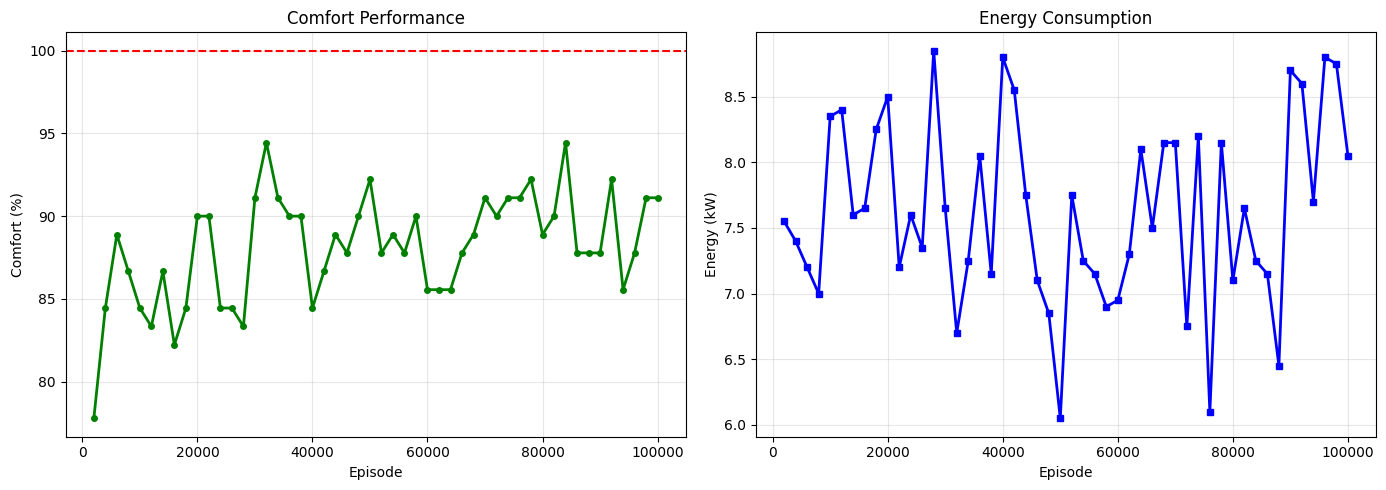

In [4]:
env = create_office_env()

def get_state_size():
    return 13 * 11 * 5

print("=" * 60)
print("SMART OFFICE AC - TRAINING START (STRICT)")
print("=" * 60)

def state_to_index(obs):
    room, out, time_p = obs
    return int((room * 11 * 5) + (out * 5) + time_p)

def evaluate_agent(env, q_table, episodes=10):
    total_working_hours = 0
    success_working_hours = 0
    total_rewards = []
    total_energies = []

    for _ in range(episodes):
        obs, _ = env.reset()
        state = state_to_index(obs)
        terminated = False
        ep_reward = 0
        ep_energy = 0

        while not terminated:
            action = np.argmax(q_table[state])
            obs, reward, terminated, _, _ = env.step(action)

            if 9 <= env.hour <= 17:
                total_working_hours += 1
                if 22.0 <= env.room_temp <= 24.0:
                    success_working_hours += 1

            state = state_to_index(obs)
            ep_reward += reward
            ep_energy += env.current_energy

        total_rewards.append(ep_reward)
        total_energies.append(ep_energy)

    success_rate = (success_working_hours / total_working_hours * 100) if total_working_hours > 0 else 0
    return np.mean(total_rewards), success_rate, np.mean(total_energies)

# Hyperparameters
state_size = get_state_size()
q_table = np.zeros([state_size, 7])
alpha = 0.1
gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.9999
epsilon_min = 0.01

num_episodes = 100000
eval_every = 2000

print("\n" + "=" * 60)
print("🚀 TRAINING IN PROGRESS...")
print("=" * 60)

best_score = -np.inf
best_comfort = 0
best_energy = float('inf')
hist_ep = []
hist_comfort = []
hist_energy = []

start_time = time.time()

for ep in range(1, num_episodes + 1):
    obs, _ = env.reset()
    state = state_to_index(obs)
    terminated = False

    while not terminated:
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[state])

        next_obs, reward, terminated, _, _ = env.step(action)
        next_state = state_to_index(next_obs)

        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        q_table[state, action] = old_value + alpha * (reward + gamma * next_max - old_value)

        state = next_state

    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    if ep % eval_every == 0:
        score, comfort, energy = evaluate_agent(env, q_table, episodes=10)
        hist_ep.append(ep)
        hist_comfort.append(comfort)
        hist_energy.append(energy)

        save_msg = ""
        # Record Logic
        if comfort > best_comfort:
            best_comfort = comfort
            best_energy = energy
            best_score = score
            np.save("best_q_table.npy", q_table)
            save_msg = "RECORD (Comfort)!"
        elif comfort == best_comfort and energy < best_energy:
            best_energy = energy
            best_score = score
            np.save("best_q_table.npy", q_table)
            save_msg = "RECORD (Energy)!"

        print(f"Ep: {ep:5,d} | Eps: {epsilon:.3f} | Comfort: %{comfort:5.1f} | "
              f"Energy: {energy:4.1f} kW | Reward: {score:6.1f} | {save_msg}")

elapsed_total = time.time() - start_time
print("\n" + "=" * 60)
print(f"✅ TRAINING COMPLETE")
print(f"⏱️  Duration: {elapsed_total/60:.1f} minutes")
print(f"🏆 Best Comfort: %{best_comfort:.1f}")
print(f"⚡ Lowest Energy: {best_energy:.1f} kW")
print(f"⭐ Best Avg Total Reward: {best_score:.1f}")
print("=" * 60 + "\n")

# Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(hist_ep, hist_comfort, 'g-o', linewidth=2, markersize=4)
ax1.set_xlabel('Episode')
ax1.set_ylabel('Comfort (%)')
ax1.set_title('Comfort Performance')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=100, color='r', linestyle='--')

ax2.plot(hist_ep, hist_energy, 'b-s', linewidth=2, markersize=4)
ax2.set_xlabel('Episode')
ax2.set_ylabel('Energy (kW)')
ax2.set_title('Energy Consumption')
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

>> 'best_q_table.npy' loaded successfully.


HOUR  | PERIOD     | OUT C    | IN C     | ACTION          | ENERGY (kW) 
00:00 | NIGHT      |  20.0    |  28.0 [X]  | OFF             | 0.0
01:00 | NIGHT      |  19.0    |  27.4 [X]  | OFF             | 0.0
02:00 | NIGHT      |  19.0    |  26.7 [X]  | OFF             | 0.0
03:00 | NIGHT      |  20.0    |  26.1 [X]  | OFF             | 0.0
04:00 | NIGHT      |  21.0    |  25.6 [X]  | OFF             | 0.0
05:00 | NIGHT      |  22.0    |  25.2 [X]  | OFF             | 0.0
06:00 | PREP       |  24.0    |  25.0 [X]  | Cool-Low        | 0.5
07:00 | PREP       |  26.0    |  24.4 [X]  | Cool-Mid        | 1.0
08:00 | PREP       |  28.0    |  23.0 [OK] | Cool-Mid        | 1.0
09:00 | WORK       |  30.0    |  21.9 [X]  | Heat-Low        | 0.5
10:00 | WORK       |  32.0    |  23.1 [OK] | Cool-Mid        | 1.0
11:00 | WORK       |  34.0    |  22.3 [OK] | Cool-Low        | 0.5
12:00 | WORK       |  35.0    |  22.7 [OK] | OFF             | 0.0
13:00 | WO

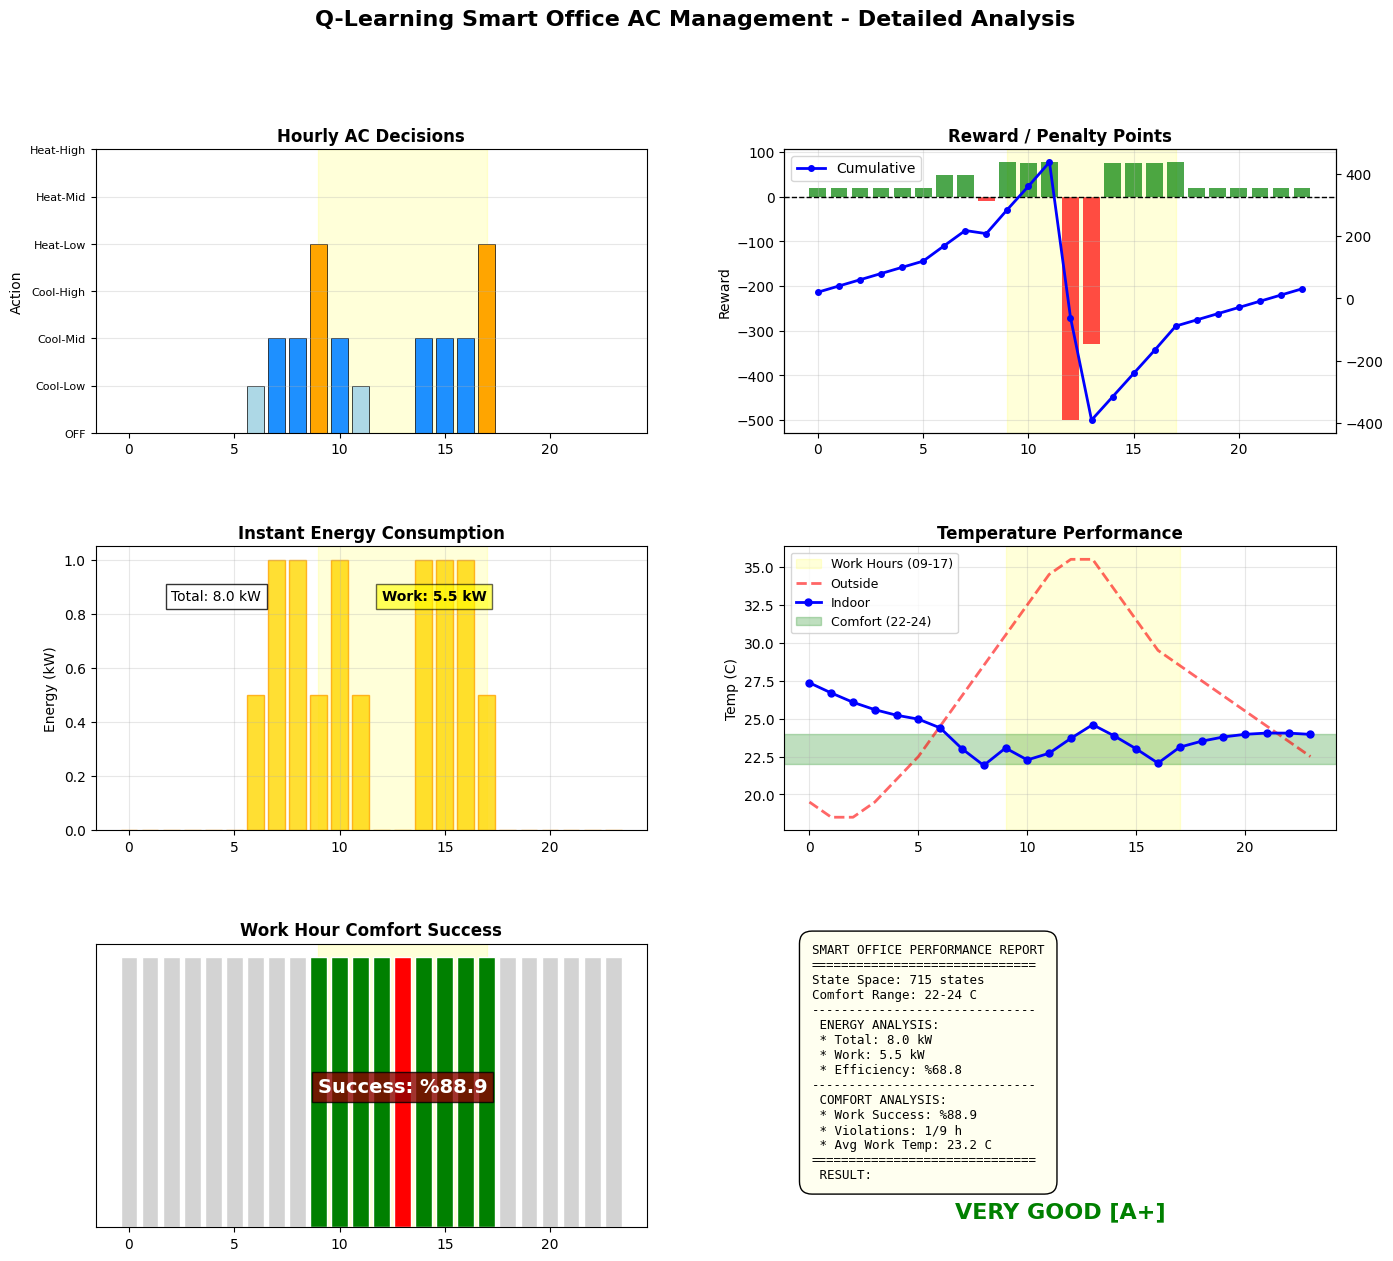


 GENERATING AND SAVING ANIMATION...
>> Animation saved to 'smart_office_result.gif' successfully.


In [6]:
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt

# Load Trained Model
try:
    best_q = np.load("best_q_table.npy")
    print(">> 'best_q_table.npy' loaded successfully.\n")
except:
    print("!! Saved file not found, using current 'q_table'.\n")
    # Fallback if running sequentially without saving
    best_q = q_table if 'q_table' in globals() else np.zeros((get_state_size(), 7))

# --- Helper for Animation ---
def show_animation(frames):
    fig = plt.figure(figsize=(6, 6))
    plt.axis('off')
    im = plt.imshow(frames[0])

    def update(frame):
        im.set_array(frame)
        return [im]

    anim = animation.FuncAnimation(fig, update, frames=frames,
                                   interval=250, blit=True)
    plt.close(fig)
    return anim

def run_office_scenario_with_anim(env, q_table, temps=STANDARD_TEMPS):

    obs, _ = env.reset(seed=42)
    env.room_temp = 28  # Start hot

    history = {
        "hours": [], "room_temp": [], "outside_temp": [],
        "actions": [], "rewards": [], "energy": []
    }
    frames = [] # Store visual frames

    ACTION_NAMES = ["OFF", "Cool-Low", "Cool-Mid", "Cool-High",
                    "Heat-Low", "Heat-Mid", "Heat-High"]

    print("\n" + "=" * 85)
    print(f"{'HOUR':<5} | {'PERIOD':<10} | {'OUT C':<8} | {'IN C':<8} | "
          f"{'ACTION':<15} | {'ENERGY (kW)':<12}")
    print("=" * 85)

    for h in range(24):
        env.outside_temp = temps[h]
        env.hour = h

        # Decision making using Q-table
        obs = env._get_obs()
        state = state_to_index(obs)
        action = np.argmax(q_table[state])

        # Logging for terminal output
        time_p = env._get_time_period(h)
        if time_p == 0: period_str = "NIGHT"
        elif time_p == 1: period_str = "PREP"
        elif time_p == 2: period_str = "WORK"
        else: period_str = "EVENING"
        act_str = ACTION_NAMES[action]
        cost = env.ENERGY_CONSUMPTION[action]
        comfort_icon = "[OK]" if 22.0 <= env.room_temp <= 24.0 else "[X]"
        print(f"{h:02d}:00 | {period_str:<10} | {env.outside_temp:5.1f}    | "
              f"{env.room_temp:5.1f} {comfort_icon:<4} | {act_str:<15} | {cost:.1f}")

        # Execute step and capture frame
        obs, reward, terminated, _, _ = env.step(action)
        frames.append(env.render())

        # Record history data
        history["hours"].append(h)
        history["room_temp"].append(env.room_temp)
        history["outside_temp"].append(env.outside_temp)
        history["actions"].append(action)
        history["rewards"].append(reward)
        history["energy"].append(env.current_energy)

    print("=" * 85 + "\n")
    return history, frames

def plot_office_dashboard(history):

    hours = history["hours"]
    actions = history["actions"]
    rewards = history["rewards"]
    room_temps = history["room_temp"]
    out_temps = history["outside_temp"]
    energies = history["energy"]

    ACTION_NAMES = ["OFF", "Cool-Low", "Cool-Mid", "Cool-High",
                    "Heat-Low", "Heat-Mid", "Heat-High"]

    fig, axes = plt.subplots(3, 2, figsize=(16, 14))
    plt.subplots_adjust(hspace=0.4, wspace=0.25)

    def highlight_work_hours(ax):
        ax.axvspan(9, 17, color='yellow', alpha=0.15, label='Work Hours (09-17)')

    # --- 1. ACTIONS ---
    ax1 = axes[0, 0]
    highlight_work_hours(ax1)
    act_colors = ['lightgray', 'lightblue', 'dodgerblue', 'darkblue',
                  'orange', 'red', 'darkred']
    colors = [act_colors[a] for a in actions]
    ax1.bar(hours, actions, color=colors, edgecolor='black', linewidth=0.5)
    ax1.set_title('Hourly AC Decisions', fontweight='bold', fontsize=12)
    ax1.set_ylabel('Action')
    ax1.set_yticks(range(7))
    ax1.set_yticklabels(ACTION_NAMES, fontsize=8)
    ax1.grid(True, alpha=0.3, axis='y')

    # --- 2. REWARDS ---
    ax2 = axes[0, 1]
    highlight_work_hours(ax2)
    rew_colors = ['green' if r > 0 else 'red' for r in rewards]
    ax2.bar(hours, rewards, color=rew_colors, alpha=0.7)
    ax2.axhline(0, color='black', linestyle='--', linewidth=1)
    ax2.set_title('Reward / Penalty Points', fontweight='bold', fontsize=12)
    ax2.set_ylabel('Reward')
    ax2.grid(True, alpha=0.3)
    ax2_twin = ax2.twinx()
    ax2_twin.plot(hours, np.cumsum(rewards), color='blue', marker='o', markersize=4, linewidth=2, label='Cumulative')
    ax2_twin.legend(loc='upper left')

    # --- 3. ENERGY ---
    ax3 = axes[1, 0]
    highlight_work_hours(ax3)
    ax3.bar(hours, energies, color='gold', edgecolor='orange', alpha=0.8)
    ax3.set_ylabel('Energy (kW)')
    ax3.set_title('Instant Energy Consumption', fontweight='bold', fontsize=12)
    ax3.grid(True, alpha=0.3)
    work_energy = sum([energies[i] for i in range(9, 18)])
    total_energy = sum(energies)
    y_pos = max(energies) * 0.85 if max(energies) > 0 else 0.5
    ax3.text(2, y_pos, f"Total: {total_energy:.1f} kW", fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
    ax3.text(12, y_pos, f"Work: {work_energy:.1f} kW", fontsize=10, fontweight='bold', bbox=dict(facecolor='yellow', alpha=0.6))

    # --- 4. TEMPERATURE ---
    ax4 = axes[1, 1]
    highlight_work_hours(ax4)
    ax4.plot(hours, out_temps, 'r--', label='Outside', alpha=0.6, linewidth=2)
    ax4.plot(hours, room_temps, 'b-o', label='Indoor', linewidth=2, markersize=5)
    ax4.axhspan(22, 24, color='green', alpha=0.25, label='Comfort (22-24)')
    ax4.set_title('Temperature Performance', fontweight='bold', fontsize=12)
    ax4.set_ylabel('Temp (C)')
    ax4.legend(loc='upper left', fontsize=9)
    ax4.grid(True, alpha=0.3)

    # --- 5. COMFORT VIOLATIONS ---
    ax5 = axes[2, 0]
    highlight_work_hours(ax5)
    status_colors = []
    violation_count = 0
    for h, t in zip(hours, room_temps):
        if 9 <= h <= 17:
            if 22.0 <= t <= 24.0: status_colors.append('green')
            else:
                status_colors.append('red')
                violation_count += 1
        else: status_colors.append('lightgray')
    ax5.bar(hours, [1] * 24, color=status_colors, edgecolor='white', linewidth=1)
    ax5.set_yticks([])
    ax5.set_title('Work Hour Comfort Success', fontweight='bold', fontsize=12)
    success_rate = ((9 - violation_count) / 9) * 100
    ax5.text(13, 0.5, f"Success: %{success_rate:.1f}", ha='center', fontsize=14, fontweight='bold', color='white',
             bbox=dict(facecolor='darkgreen' if success_rate >= 90 else 'darkred', alpha=0.8))

    # --- 6. REPORT CARD ---
    ax6 = axes[2, 1]
    ax6.axis('off')
    night_energy = total_energy - work_energy
    avg_mesai_temp = np.mean([room_temps[i] for i in range(9, 18)])
    summary_text = (
        f"SMART OFFICE PERFORMANCE REPORT\n{'='*30}\n"
        f"State Space: {get_state_size()} states\nComfort Range: 22-24 C\n{'-'*30}\n"
        f" ENERGY ANALYSIS:\n * Total: {total_energy:.1f} kW\n * Work: {work_energy:.1f} kW\n"
        f" * Efficiency: %{(work_energy/total_energy*100 if total_energy>0 else 0):.1f}\n{'-'*30}\n"
        f" COMFORT ANALYSIS:\n * Work Success: %{success_rate:.1f}\n * Violations: {violation_count}/9 h\n"
        f" * Avg Work Temp: {avg_mesai_temp:.1f} C\n{'='*30}\n RESULT: "
    )
    if success_rate >= 95 and work_energy < 15: result, r_color = "EXCELLENT! [AAA]", 'darkgreen'
    elif success_rate >= 80: result, r_color = "VERY GOOD [A+]", 'green'
    elif success_rate >= 60: result, r_color = "GOOD [B]", 'orange'
    else: result, r_color = "NEEDS IMPROVEMENT", 'red'
    ax6.text(0.05, 1.0, summary_text, fontsize=9, family='monospace', va='top', transform=ax6.transAxes,
             bbox=dict(facecolor='ivory', edgecolor='black', boxstyle='round,pad=1'))
    ax6.text(0.5, 0.02, result, fontsize=16, fontweight='bold', ha='center', va='bottom', transform=ax6.transAxes, color=r_color)

    plt.suptitle("Q-Learning Smart Office AC Management - Detailed Analysis", fontsize=16, fontweight='bold', y=0.98)
    plt.show()

# --- EXECUTION ---

# 1. Run scenario and get data + frames
env = create_office_env()
trained_history, trained_frames = run_office_scenario_with_anim(env, best_q, STANDARD_TEMPS)

# 2. Show static dashboard
plot_office_dashboard(trained_history)

print("\n" + "=" * 60)
print(" GENERATING AND SAVING ANIMATION...")
print("=" * 60)

# 3. Create animation object
trained_anim = show_animation(trained_frames)

# 4. SAVE ANIMATION
file_name = "smart_office_result.gif"
trained_anim.save(file_name, writer="pillow", fps=4)
print(f">> Animation saved to '{file_name}' successfully.")

# 5. Show in Notebook
HTML(trained_anim.to_jshtml())